In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
from src.mlmodel import *
import src.utils as utils
from ZSTL_GPU import ZSTL
import pandas as pd
import itertools
import timeit

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !ls ./drive/'My Drive'/'thesis_data'/'awa2'/
# !cp ./drive/'My Drive'/'thesis_data'/'awa2'/'task_train_data_binary.pickle' ./

In [4]:
net = FuncRecursiveNet([
    FLinearLayer(1, True)
])
shape_record = {0: [(1, 2049)]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
kb_size = 10
train_size = 30

In [6]:

filename = './ZSTL_Data/Animals_with_Attributes2/splitedTask/task_train_data_binary.pickle'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
print(len(dataset), len(list(dataset.keys())))
print(type(dataset))

total_len = len(dataset)
test_size = total_len - kb_size - train_size


50 50
<class 'dict'>


In [7]:
#np.random.seed(666)
indx = [ x+1 for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])
support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=int(test_size), shuffle=True)

support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)
print('sum ',torch.sum(support_a, dim=0))

train_a, train_w, train_x, train_y = next(iter(train_loader))
print(train_a.shape)

train_a, train_w, train_x, train_y = train_a.float(), train_w.float(), train_x.float(), train_y.float()
print(train_a.shape, train_w.shape, train_x.shape, train_y.shape)

10
30
10
85
2049
sum  tensor([34., 31., 26., 27., 31., 31., 39., 31., 37., 34.])
torch.Size([30, 1, 85])
torch.Size([30, 1, 85]) torch.Size([30, 1, 2049]) torch.Size([30, 200, 2049]) torch.Size([30, 200, 1])


{'rho': 1, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.0001, 'align lr': 0.0001, 'dm': 85, 'd': 2049, 'model_shape': {0: [(1, 2049)]}, 'atten_activation': 'Sparsemax'}
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.491; align loss 0.011182630434632301
1/300 o_loss 20.641205008824667; m train metric 0.49149999999999994; m test metric 0.4915; align loss  0.008148573338985443
20/300 o_loss 17.975731774171194; m train metric 0.5026666666666667; m test metric 0.5105; align loss  0.008061590604484081
40/300 o_loss 16.144432964921; m train metric 0.5420000000000001; m test metric 0.537; align loss  0.007990783080458641
60/300 o_loss 14.641975205143293; m train metric 0.568; m test metric 0.566; align loss  0.007927656173706055
80/300 o_loss 13.350726022322974; m train metric 0.5903333333333335; m test metric 0.589; align loss  0.00786508247256279
100/300 o_loss 12.230108210

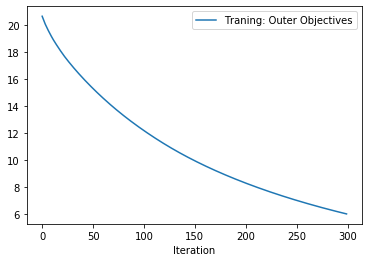

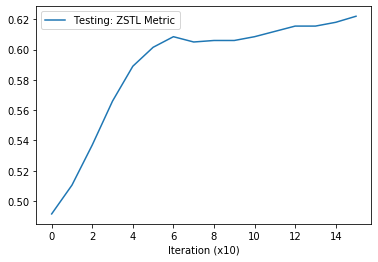

Time: 51.425334995000014


In [8]:


param_dict = {}
param_dict['rho'] = 1
param_dict['mu'] = 1e-5
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-4
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)

start = timeit.default_timer()
ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=300)
stop = timeit.default_timer()
print('Time:', stop - start)

5
25
25
5
num of hp  36
rho for w_kb 1; mu for a_kb 1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 311.0111389160156
1/400 o_loss 22.951665534973145; m train metric 0.4912; m test metric 0.48900000000000005; align loss  0.071929931640625
20/400 o_loss 19.956025714278223; m train metric 0.5478000000000001; m test metric 0.55; align loss  0.071624755859375
40/400 o_loss 18.041290360093118; m train metric 0.5882000000000001; m test metric 0.592; align loss  0.071441650390625
60/400 o_loss 16.454373208880426; m train metric 0.6210000000000001; m test metric 0.601; align loss  0.07110595703125
80/400 o_loss 15.085601865053176; m train metric 0.6544; m test metric 0.603; align loss  0.0709228515625
100/400 o_loss 13.888619246482849; m train metric 0.6768000000000001; m test metric 0.6; align loss  0.07061767578125
120/400 o_loss 12.832588798999787; m 

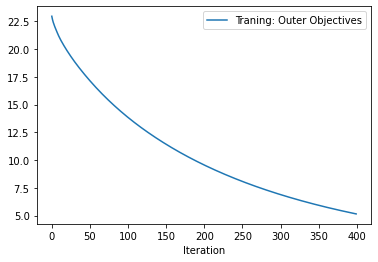

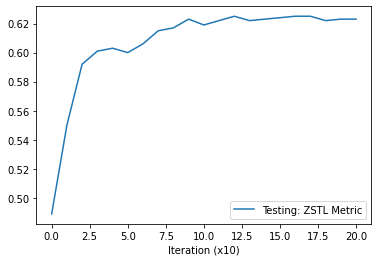

mean metric 0.623
New best acc 0.623
rho for w_kb 1; mu for a_kb 0.1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 31.111127853393555
1/400 o_loss 22.951665534973145; m train metric 0.4912; m test metric 0.489; align loss  0.015913009643554688
20/400 o_loss 19.95602572619915; m train metric 0.5478000000000002; m test metric 0.55; align loss  0.015802383422851562
40/400 o_loss 18.04129038631916; m train metric 0.5882; m test metric 0.592; align loss  0.015722274780273438
60/400 o_loss 16.45437321126461; m train metric 0.6210000000000001; m test metric 0.601; align loss  0.015630722045898438
80/400 o_loss 15.085603806376458; m train metric 0.6544; m test metric 0.603; align loss  0.015554428100585938
100/400 o_loss 13.888619236946106; m train metric 0.6768; m test metric 0.6; align loss  0.015462875366210938
120/400 o_loss 12.832588824629784; m train metric 0.69

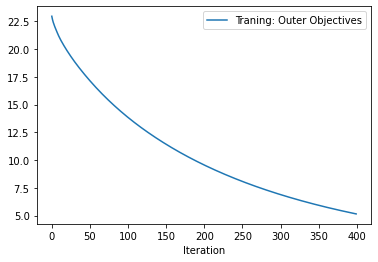

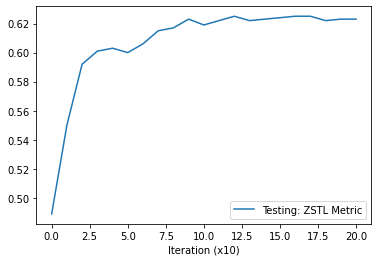

mean metric 0.623
New best acc 0.623
rho for w_kb 1; mu for a_kb 0.01;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 3.1211230754852295
1/400 o_loss 22.951665534973145; m train metric 0.49119999999999997; m test metric 0.48900000000000005; align loss  0.01031184196472168
20/400 o_loss 19.956025735735892; m train metric 0.5478000000000001; m test metric 0.55; align loss  0.010217666625976562
40/400 o_loss 18.04129035383463; m train metric 0.5882000000000001; m test metric 0.592; align loss  0.010148763656616211
60/400 o_loss 16.45437321484089; m train metric 0.621; m test metric 0.601; align loss  0.010081768035888672
80/400 o_loss 15.085601873993873; m train metric 0.6544; m test metric 0.603; align loss  0.01001596450805664
100/400 o_loss 13.888619223237038; m train metric 0.6768000000000001; m test metric 0.6; align loss  0.009948015213012695
12

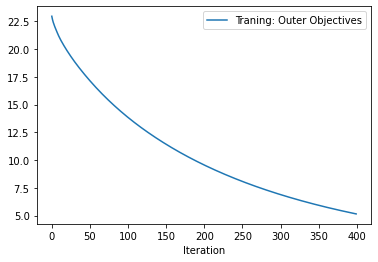

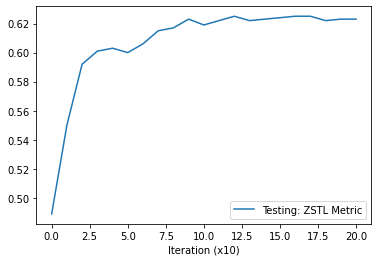

mean metric 0.623
New best acc 0.623
rho for w_kb 1; mu for a_kb 0.001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 0.3221230208873749
1/400 o_loss 22.951665534973145; m train metric 0.49119999999999997; m test metric 0.48900000000000005; align loss  0.00975191593170166
20/400 o_loss 19.956025790572166; m train metric 0.5478000000000001; m test metric 0.55; align loss  0.009659409523010254
40/400 o_loss 18.041290373206138; m train metric 0.5882; m test metric 0.592; align loss  0.00959157943725586
60/400 o_loss 16.454373204112052; m train metric 0.6210000000000001; m test metric 0.601; align loss  0.009527087211608887
80/400 o_loss 15.085601879358292; m train metric 0.6544000000000001; m test metric 0.603; align loss  0.009462237358093262
100/400 o_loss 13.888619214296341; m train metric 0.6768; m test metric 0.6; align loss  0.00939631462097168

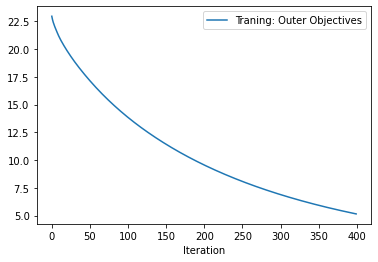

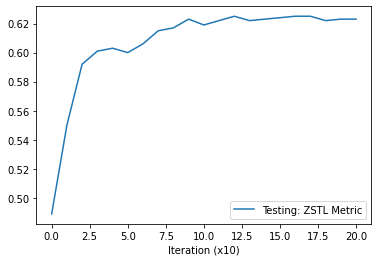

mean metric 0.623
New best acc 0.623
rho for w_kb 1; mu for a_kb 0.0001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.04222298040986061
1/400 o_loss 22.951665534973145; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.009695921093225479
20/400 o_loss 19.956025666296483; m train metric 0.5478000000000001; m test metric 0.55; align loss  0.009603599086403847
40/400 o_loss 18.04129032790661; m train metric 0.5882000000000002; m test metric 0.592; align loss  0.009535850957036018
60/400 o_loss 16.45437311887741; m train metric 0.621; m test metric 0.601; align loss  0.009471649304032326
80/400 o_loss 15.085601813197137; m train metric 0.6544000000000001; m test metric 0.603; align loss  0.009406883269548416
100/400 o_loss 13.888619186282158; m train metric 0.6768000000000001; m test metric 0.6; align loss  0.009341204538941383
120/400 o_los

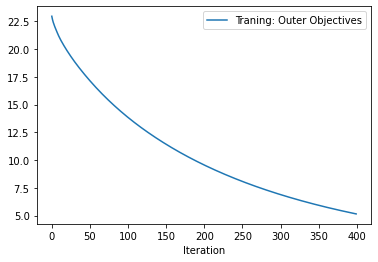

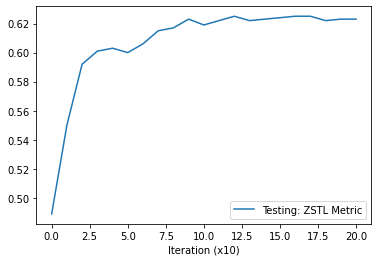

mean metric 0.623
New best acc 0.623
rho for w_kb 1; mu for a_kb 1e-05;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.014232977293431759
1/400 o_loss 22.951665534973145; m train metric 0.4911999999999999; m test metric 0.489; align loss  0.009690319187939167
20/400 o_loss 19.956025449335574; m train metric 0.5478000000000001; m test metric 0.55; align loss  0.009598040953278542
40/400 o_loss 18.041289950609208; m train metric 0.5882; m test metric 0.592; align loss  0.009530344977974892
60/400 o_loss 16.45437263727188; m train metric 0.6210000000000001; m test metric 0.6010000000000001; align loss  0.00946620013564825
80/400 o_loss 15.085603330135346; m train metric 0.6544; m test metric 0.603; align loss  0.009401480667293072
100/400 o_loss 13.888618757128716; m train metric 0.6768000000000001; m test metric 0.5999999999999999; align loss  0.0093358531594276

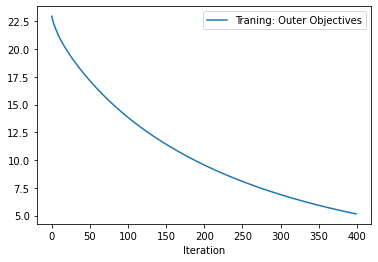

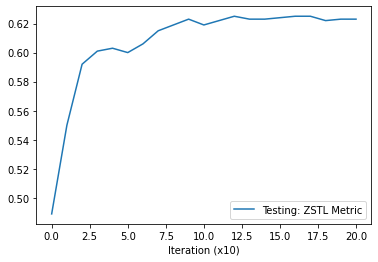

mean metric 0.623
New best acc 0.623
rho for w_kb 0.1; mu for a_kb 1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 311.0111389160156
1/400 o_loss 5.213823332786561; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.0718994140625
20/400 o_loss 3.4074419140815735; m train metric 0.5660000000000001; m test metric 0.5700000000000001; align loss  0.071624755859375
40/400 o_loss 2.7884199267625807; m train metric 0.6417999999999999; m test metric 0.6260000000000001; align loss  0.0714111328125
60/400 o_loss 2.5003025871515274; m train metric 0.7058; m test metric 0.6319999999999999; align loss  0.071075439453125
80/400 o_loss 2.325958774089813; m train metric 0.7336; m test metric 0.627; align loss  0.070892333984375
100/400 o_loss 2.1914174968004225; m train metric 0.7470000000000002; m test metric 0.619; align loss  0.070587158203125
120/400 o

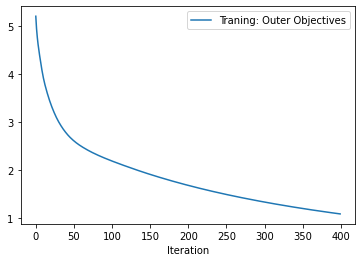

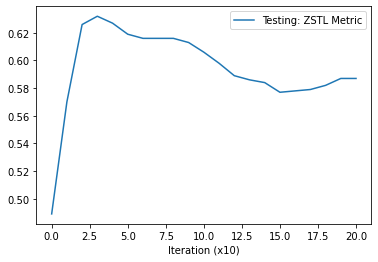

mean metric 0.587
rho for w_kb 0.1; mu for a_kb 0.1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 31.111127853393555
1/400 o_loss 5.213823332786561; m train metric 0.4912; m test metric 0.489; align loss  0.015913009643554688
20/400 o_loss 3.407441989779472; m train metric 0.5660000000000001; m test metric 0.5700000000000001; align loss  0.015787124633789062
40/400 o_loss 2.7884198969602583; m train metric 0.6417999999999999; m test metric 0.6260000000000001; align loss  0.015695571899414062
60/400 o_loss 2.5003025674819948; m train metric 0.7058000000000001; m test metric 0.632; align loss  0.015594482421875
80/400 o_loss 2.325958794951439; m train metric 0.7336; m test metric 0.627; align loss  0.015514373779296875
100/400 o_loss 2.191417475640774; m train metric 0.747; m test metric 0.619; align loss  0.015422821044921875
120/400 o_loss 2.073175379931927; m

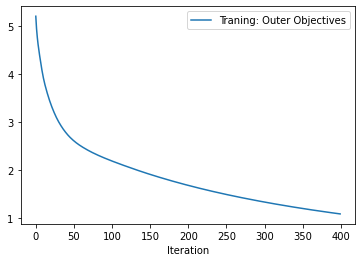

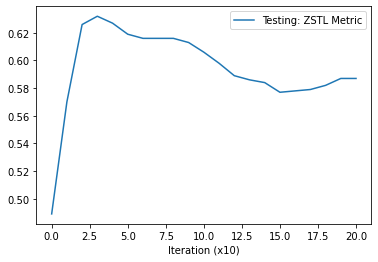

mean metric 0.587
rho for w_kb 0.1; mu for a_kb 0.01;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 3.1211230754852295
1/400 o_loss 5.213823332786561; m train metric 0.49119999999999997; m test metric 0.48900000000000005; align loss  0.010310888290405273
20/400 o_loss 3.407441968023777; m train metric 0.5660000000000001; m test metric 0.5700000000000001; align loss  0.010202646255493164
40/400 o_loss 2.788419885635376; m train metric 0.6418; m test metric 0.6260000000000001; align loss  0.010122060775756836
60/400 o_loss 2.500302947163582; m train metric 0.7058000000000003; m test metric 0.632; align loss  0.010046958923339844
80/400 o_loss 2.325958788394928; m train metric 0.7336000000000001; m test metric 0.627; align loss  0.009977340698242188
100/400 o_loss 2.1914175006747247; m train metric 0.7470000000000002; m test metric 0.619; align loss 

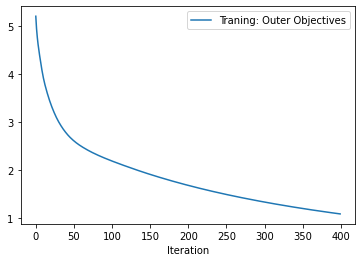

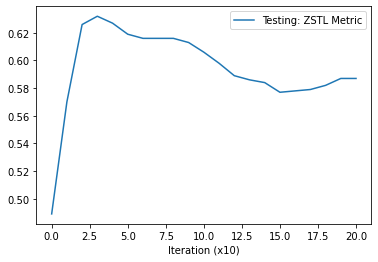

mean metric 0.587
rho for w_kb 0.1; mu for a_kb 0.001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.3221230208873749
1/400 o_loss 5.213823332786561; m train metric 0.49119999999999986; m test metric 0.489; align loss  0.00975114107131958
20/400 o_loss 3.4074419313669204; m train metric 0.566; m test metric 0.5700000000000001; align loss  0.00964421033859253
40/400 o_loss 2.7884199303388595; m train metric 0.6418; m test metric 0.626; align loss  0.009564787149429321
60/400 o_loss 2.5003025794029234; m train metric 0.7058000000000003; m test metric 0.632; align loss  0.009492307901382446
80/400 o_loss 2.3259587943553925; m train metric 0.7335999999999998; m test metric 0.627; align loss  0.009423524141311646
100/400 o_loss 2.191417513489723; m train metric 0.747; m test metric 0.619; align loss  0.009356439113616943
120/400 o_loss 2.0731754001975062; m train 

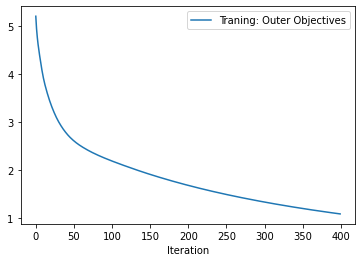

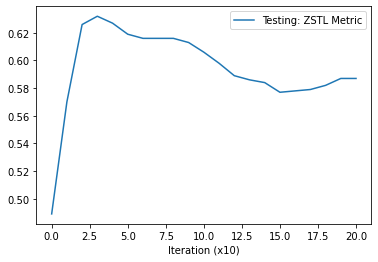

mean metric 0.587
rho for w_kb 0.1; mu for a_kb 0.0001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.04222298040986061
1/400 o_loss 5.213823332786561; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.009695138782262802
20/400 o_loss 3.4074418485164646; m train metric 0.5660000000000001; m test metric 0.5700000000000001; align loss  0.00958840362727642
40/400 o_loss 2.7884198993444445; m train metric 0.6418; m test metric 0.626; align loss  0.009509062394499779
60/400 o_loss 2.5003025767207143; m train metric 0.7058000000000003; m test metric 0.632; align loss  0.009436843916773796
80/400 o_loss 2.325958766937256; m train metric 0.7336; m test metric 0.627; align loss  0.00936819240450859
100/400 o_loss 2.191417453289032; m train metric 0.747; m test metric 0.619; align loss  0.009301306679844856
120/400 o_loss 2.0731753751635553; m trai

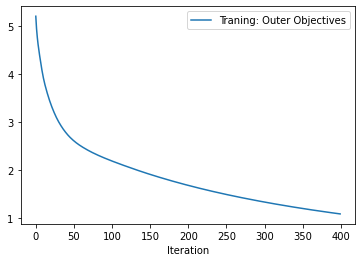

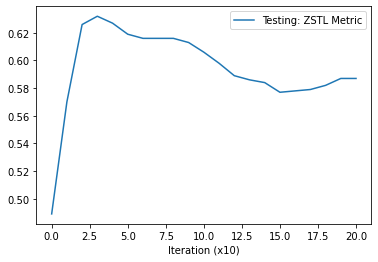

mean metric 0.587
rho for w_kb 0.1; mu for a_kb 1e-05;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.014232977293431759
1/400 o_loss 5.213823332786561; m train metric 0.4912; m test metric 0.489; align loss  0.009689539670944214
20/400 o_loss 3.407441633939743; m train metric 0.5660000000000001; m test metric 0.5700000000000001; align loss  0.009582847356796265
40/400 o_loss 2.7884192937612533; m train metric 0.6418; m test metric 0.626; align loss  0.00950356014072895
60/400 o_loss 2.5003024178743365; m train metric 0.7058000000000001; m test metric 0.632; align loss  0.009431393817067146
80/400 o_loss 2.3259586000442507; m train metric 0.7335999999999998; m test metric 0.627; align loss  0.009362789802253246
100/400 o_loss 2.1914172652363777; m train metric 0.7469999999999999; m test metric 0.619; align loss  0.009295957162976265
120/400 o_loss 2.0731752753

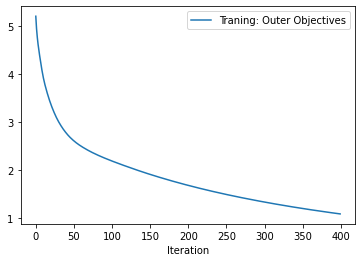

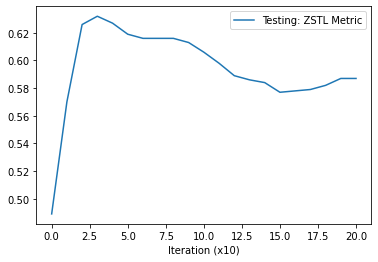

mean metric 0.587
rho for w_kb 0.01; mu for a_kb 1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 311.0111389160156
1/400 o_loss 3.440039127469063; m train metric 0.49119999999999986; m test metric 0.489; align loss  0.0718994140625
20/400 o_loss 1.6695762795209885; m train metric 0.5670000000000001; m test metric 0.573; align loss  0.071624755859375
40/400 o_loss 1.0969574022293092; m train metric 0.6466; m test metric 0.634; align loss  0.0714111328125
60/400 o_loss 0.8811168116331101; m train metric 0.7119999999999999; m test metric 0.639; align loss  0.071075439453125
80/400 o_loss 0.7992103898525238; m train metric 0.7386000000000001; m test metric 0.6239999999999999; align loss  0.07086181640625
100/400 o_loss 0.7566314926743507; m train metric 0.7518; m test metric 0.617; align loss  0.070556640625
120/400 o_loss 0.7185763084888458; m train metric 0.7646

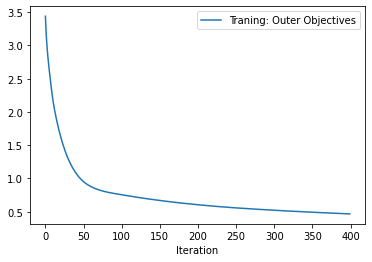

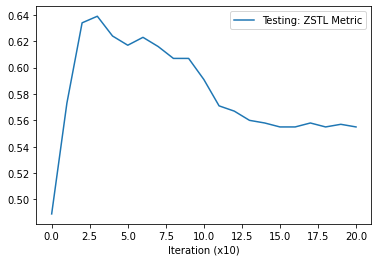

mean metric 0.555
rho for w_kb 0.01; mu for a_kb 0.1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 31.111127853393555
1/400 o_loss 3.440039127469063; m train metric 0.49119999999999997; m test metric 0.48900000000000005; align loss  0.015913009643554688
20/400 o_loss 1.6695763021707535; m train metric 0.5670000000000001; m test metric 0.573; align loss  0.015783309936523438
40/400 o_loss 1.0969574332237244; m train metric 0.6466; m test metric 0.634; align loss  0.015687942504882812
60/400 o_loss 0.8811168491840363; m train metric 0.7120000000000001; m test metric 0.639; align loss  0.0155792236328125
80/400 o_loss 0.7992103877663612; m train metric 0.7385999999999998; m test metric 0.6239999999999999; align loss  0.015491485595703125
100/400 o_loss 0.7566314813494682; m train metric 0.7518; m test metric 0.617; align loss  0.015390396118164062
1

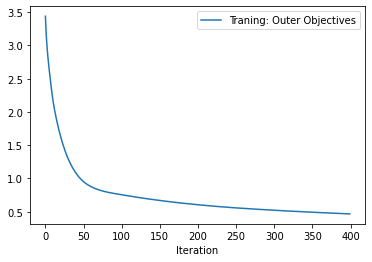

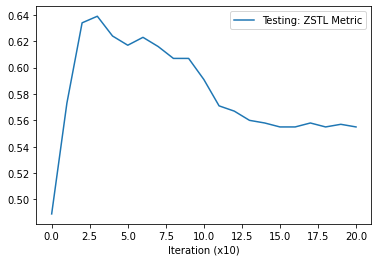

mean metric 0.5549999999999999
rho for w_kb 0.01; mu for a_kb 0.01;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 3.1211230754852295
1/400 o_loss 3.440039127469063; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.010310888290405273
20/400 o_loss 1.6695762461423873; m train metric 0.567; m test metric 0.573; align loss  0.010199546813964844
40/400 o_loss 1.096957419514656; m train metric 0.6466000000000001; m test metric 0.6340000000000001; align loss  0.010113954544067383
60/400 o_loss 0.8811168283224106; m train metric 0.7119999999999999; m test metric 0.639; align loss  0.010031700134277344
80/400 o_loss 0.7992103937268257; m train metric 0.7386; m test metric 0.6239999999999999; align loss  0.009953498840332031
100/400 o_loss 0.7566314908862114; m train metric 0.7517999999999999; m test metric 0.6170000000000001; align loss  0.00987529

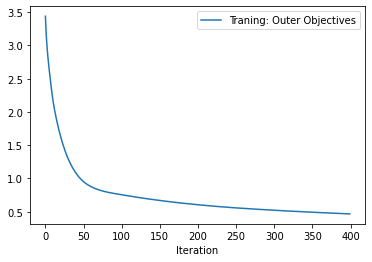

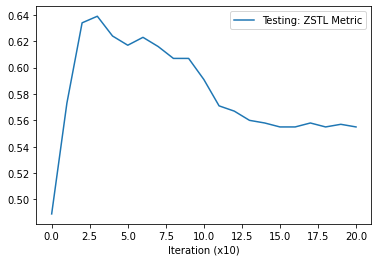

mean metric 0.5549999999999999
rho for w_kb 0.01; mu for a_kb 0.001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 0.3221230208873749
1/400 o_loss 3.440039127469063; m train metric 0.49119999999999997; m test metric 0.48900000000000005; align loss  0.009751081466674805
20/400 o_loss 1.6695763236284256; m train metric 0.5670000000000001; m test metric 0.573; align loss  0.009641200304031372
40/400 o_loss 1.0969573986530303; m train metric 0.6466; m test metric 0.634; align loss  0.009556740522384644
60/400 o_loss 0.8811168360710144; m train metric 0.7120000000000001; m test metric 0.639; align loss  0.009477019309997559
80/400 o_loss 0.7992104116082192; m train metric 0.7385999999999998; m test metric 0.624; align loss  0.009399652481079102
100/400 o_loss 0.7566314807534218; m train metric 0.7517999999999998; m test metric 0.617; align loss  0.0093

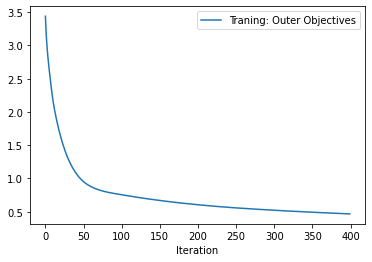

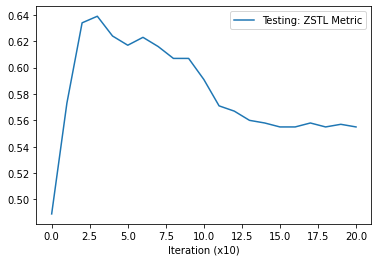

mean metric 0.5549999999999999
rho for w_kb 0.01; mu for a_kb 0.0001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.04222298040986061
1/400 o_loss 3.440039127469063; m train metric 0.4911999999999999; m test metric 0.489; align loss  0.009695090353488922
20/400 o_loss 1.6695762187242509; m train metric 0.5670000000000001; m test metric 0.573; align loss  0.009585393592715263
40/400 o_loss 1.096957411766052; m train metric 0.6466; m test metric 0.634; align loss  0.009501015767455101
60/400 o_loss 0.8811168122291565; m train metric 0.7120000000000001; m test metric 0.639; align loss  0.009421581402420998
80/400 o_loss 0.7992103746533394; m train metric 0.7386; m test metric 0.624; align loss  0.009344320744276047
100/400 o_loss 0.7566314685344696; m train metric 0.7518; m test metric 0.617; align loss  0.009268509224057198
120/400 o_loss 0.7185762828588486; m 

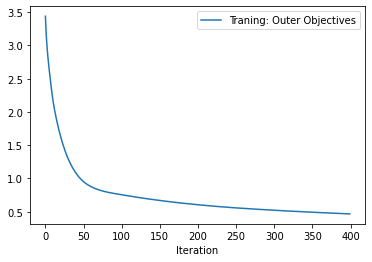

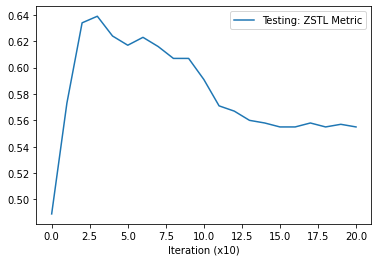

mean metric 0.5549999999999999
rho for w_kb 0.01; mu for a_kb 1e-05;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.014232977293431759
1/400 o_loss 3.440039127469063; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.009689489379525185
20/400 o_loss 1.6695760011672973; m train metric 0.5670000000000001; m test metric 0.573; align loss  0.009579835459589958
40/400 o_loss 1.0969571805000307; m train metric 0.6466; m test metric 0.634; align loss  0.009495511651039124
60/400 o_loss 0.881116752922535; m train metric 0.7120000000000001; m test metric 0.639; align loss  0.009416132234036922
80/400 o_loss 0.7992102679610252; m train metric 0.7385999999999998; m test metric 0.624; align loss  0.009338919073343277
100/400 o_loss 0.7566313377022743; m train metric 0.7518; m test metric 0.617; align loss  0.009263158775866032
120/400 o_loss 0.7185768

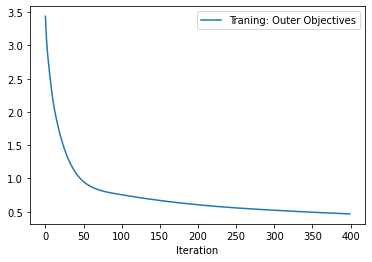

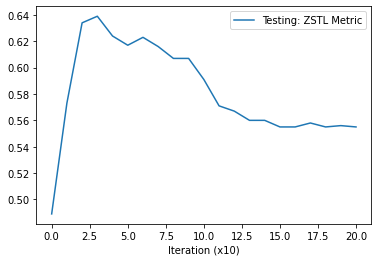

mean metric 0.555
rho for w_kb 0.001; mu for a_kb 1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 311.0111389160156
1/400 o_loss 3.262660718858242; m train metric 0.4911999999999999; m test metric 0.489; align loss  0.0718994140625
20/400 o_loss 1.4948020593076945; m train metric 0.567; m test metric 0.5740000000000001; align loss  0.071624755859375
40/400 o_loss 0.9236251098662615; m train metric 0.6466; m test metric 0.634; align loss  0.0714111328125
60/400 o_loss 0.708898656219244; m train metric 0.7118000000000001; m test metric 0.638; align loss  0.071044921875
80/400 o_loss 0.6286689284443855; m train metric 0.7384000000000002; m test metric 0.624; align loss  0.07086181640625
100/400 o_loss 0.5880994240939618; m train metric 0.7513999999999998; m test metric 0.616; align loss  0.070526123046875
120/400 o_loss 0.551830597743392; m train metric 0.7641999

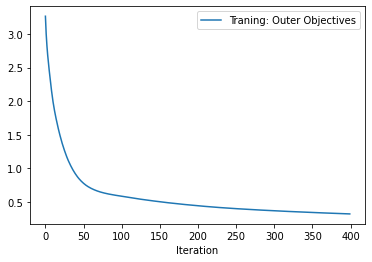

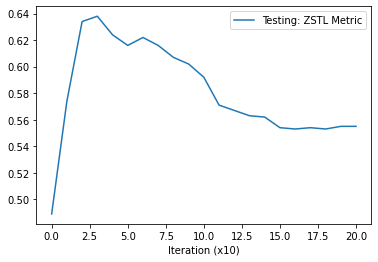

mean metric 0.5549999999999999
rho for w_kb 0.001; mu for a_kb 0.1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 31.111127853393555
1/400 o_loss 3.262660718858242; m train metric 0.4912; m test metric 0.489; align loss  0.015913009643554688
20/400 o_loss 1.4948020211607218; m train metric 0.5670000000000001; m test metric 0.574; align loss  0.015783309936523438
40/400 o_loss 0.9236251152306796; m train metric 0.6466; m test metric 0.634; align loss  0.015687942504882812
60/400 o_loss 0.7088986472785473; m train metric 0.7117999999999999; m test metric 0.6380000000000001; align loss  0.0155792236328125
80/400 o_loss 0.6286689564585686; m train metric 0.7383999999999997; m test metric 0.624; align loss  0.015489578247070312
100/400 o_loss 0.5880994309484959; m train metric 0.7513999999999998; m test metric 0.616; align loss  0.015386581420898438
120/400 o_loss 0

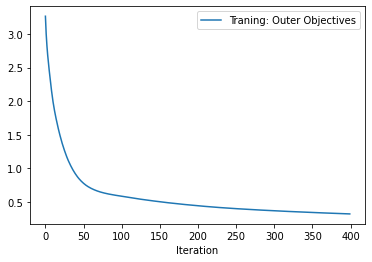

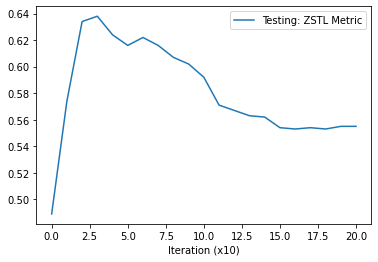

mean metric 0.5549999999999999
rho for w_kb 0.001; mu for a_kb 0.01;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 3.1211230754852295
1/400 o_loss 3.262660718858242; m train metric 0.49119999999999997; m test metric 0.48900000000000005; align loss  0.010310888290405273
20/400 o_loss 1.4948020223528147; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.010199308395385742
40/400 o_loss 0.9236251700669528; m train metric 0.6466000000000001; m test metric 0.6339999999999999; align loss  0.01011347770690918
60/400 o_loss 0.7088986472785473; m train metric 0.7117999999999999; m test metric 0.638; align loss  0.010030269622802734
80/400 o_loss 0.6286689305305481; m train metric 0.7384; m test metric 0.624; align loss  0.009950876235961914
100/400 o_loss 0.5880994360148907; m train metric 0.7513999999999998; m test metric 

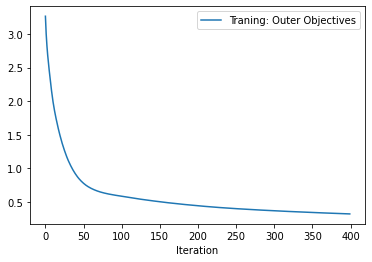

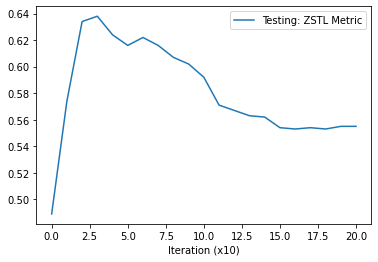

mean metric 0.5549999999999999
rho for w_kb 0.001; mu for a_kb 0.001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 0.3221230208873749
1/400 o_loss 3.262660718858242; m train metric 0.49119999999999997; m test metric 0.48900000000000005; align loss  0.009751081466674805
20/400 o_loss 1.4948020032793283; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.009640991687774658
40/400 o_loss 0.9236251027137041; m train metric 0.6466; m test metric 0.634; align loss  0.009556204080581665
60/400 o_loss 0.7088986448943615; m train metric 0.7118000000000001; m test metric 0.638; align loss  0.0094757080078125
80/400 o_loss 0.6286689469218254; m train metric 0.7384000000000001; m test metric 0.624; align loss  0.009397059679031372
100/400 o_loss 0.5880994240939618; m train metric 0.7514; m test metric 0.616; align loss  0.0093

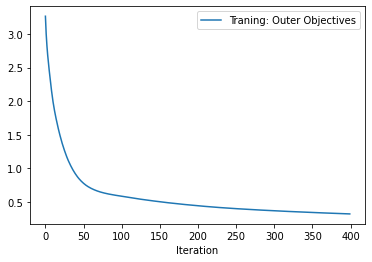

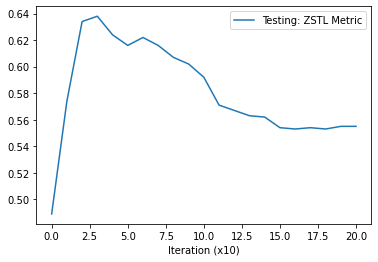

mean metric 0.555
rho for w_kb 0.001; mu for a_kb 0.0001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 0.04222298040986061
1/400 o_loss 3.262660718858242; m train metric 0.4912; m test metric 0.48900000000000005; align loss  0.009695090353488922
20/400 o_loss 1.4948020190745592; m train metric 0.5670000000000001; m test metric 0.574; align loss  0.009585196152329445
40/400 o_loss 0.9236251265555621; m train metric 0.6466000000000001; m test metric 0.634; align loss  0.009500468149781227
60/400 o_loss 0.708898650854826; m train metric 0.7117999999999999; m test metric 0.638; align loss  0.00942024402320385
80/400 o_loss 0.6286689361929894; m train metric 0.7384000000000002; m test metric 0.624; align loss  0.00934172049164772
100/400 o_loss 0.5880994300544262; m train metric 0.7514; m test metric 0.616; align loss  0.009264284744858742
120/400 o_l

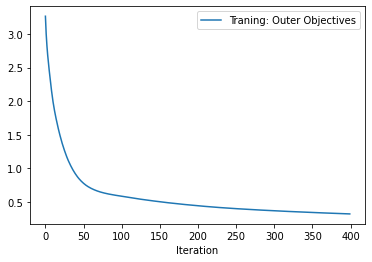

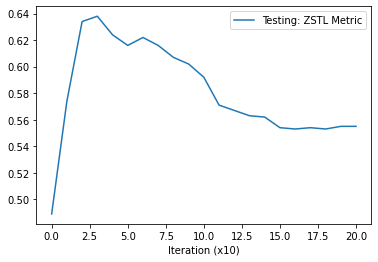

mean metric 0.5549999999999999
rho for w_kb 0.001; mu for a_kb 1e-05;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.014232977293431759
1/400 o_loss 3.262660718858242; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.009689489379525185
20/400 o_loss 1.494801812246442; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.009579641744494438
40/400 o_loss 0.9236249221116305; m train metric 0.6466; m test metric 0.634; align loss  0.0094949621707201
60/400 o_loss 0.708898525685072; m train metric 0.7118000000000002; m test metric 0.638; align loss  0.0094147939234972
80/400 o_loss 0.6286687800288201; m train metric 0.7384000000000001; m test metric 0.6239999999999999; align loss  0.009336319752037525
100/400 o_loss 0.588099364489317; m train metric 0.7514; m test metric 0.616; align loss  0.009258934296667576
120

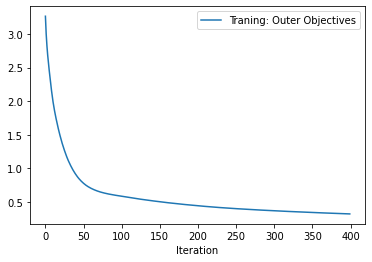

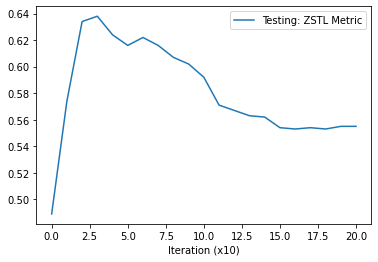

mean metric 0.5549999999999999
rho for w_kb 0.0001; mu for a_kb 1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 311.0111389160156
1/400 o_loss 3.2449228748306633; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.0718994140625
20/400 o_loss 1.4773189906775952; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.071624755859375
40/400 o_loss 0.9062641356466338; m train metric 0.6466; m test metric 0.634; align loss  0.0714111328125
60/400 o_loss 0.6915347047150135; m train metric 0.7118000000000001; m test metric 0.6380000000000001; align loss  0.071044921875
80/400 o_loss 0.6114277961244807; m train metric 0.7384; m test metric 0.624; align loss  0.07086181640625
100/400 o_loss 0.5709362510265783; m train metric 0.7515999999999999; m test metric 0.616; align loss  0.070526123046875
120/400 o_loss 0.5347693655

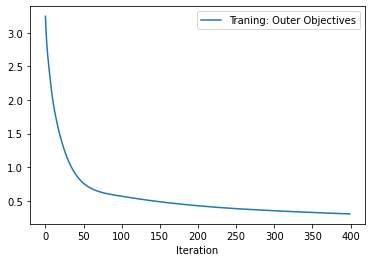

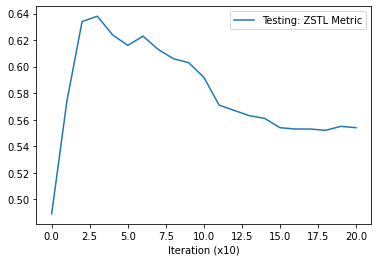

mean metric 0.554
rho for w_kb 0.0001; mu for a_kb 0.1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 31.111127853393555
1/400 o_loss 3.2449228748306633; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.015913009643554688
20/400 o_loss 1.4773190154135227; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.015783309936523438
40/400 o_loss 0.9062641416070983; m train metric 0.6466; m test metric 0.634; align loss  0.015687942504882812
60/400 o_loss 0.691534681469202; m train metric 0.7117999999999999; m test metric 0.638; align loss  0.0155792236328125
80/400 o_loss 0.6114277922501787; m train metric 0.7384000000000001; m test metric 0.6239999999999999; align loss  0.0154876708984375
100/400 o_loss 0.5709362522186712; m train metric 0.7515999999999998; m test metric 0.6159999999999999; align loss  0.0153865814

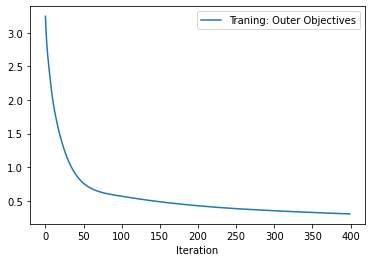

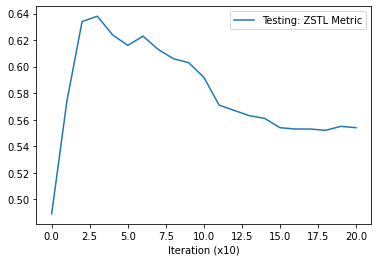

mean metric 0.554
rho for w_kb 0.0001; mu for a_kb 0.01;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 3.1211230754852295
1/400 o_loss 3.2449228748306633; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.010310888290405273
20/400 o_loss 1.477319028824568; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.010199308395385742
40/400 o_loss 0.906264157104306; m train metric 0.6466; m test metric 0.634; align loss  0.01011347770690918
60/400 o_loss 0.6915346844494343; m train metric 0.7118000000000001; m test metric 0.638; align loss  0.010030269622802734
80/400 o_loss 0.6114277850976214; m train metric 0.7384; m test metric 0.6239999999999999; align loss  0.009950637817382812
100/400 o_loss 0.5709362593712285; m train metric 0.7515999999999999; m test metric 0.616; align loss  0.009870767593383789
120/400 o_los

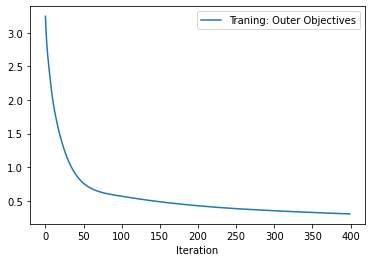

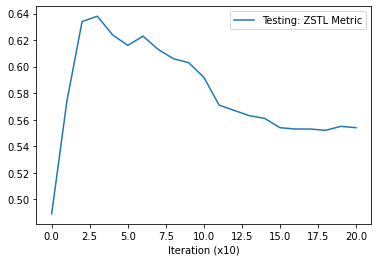

mean metric 0.554
rho for w_kb 0.0001; mu for a_kb 0.001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.3221230208873749
1/400 o_loss 3.2449228748306633; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.009751081466674805
20/400 o_loss 1.4773189954459667; m train metric 0.5670000000000001; m test metric 0.574; align loss  0.009640991687774658
40/400 o_loss 0.9062641600845381; m train metric 0.6466000000000001; m test metric 0.6340000000000001; align loss  0.00955614447593689
60/400 o_loss 0.6915346874296665; m train metric 0.7117999999999999; m test metric 0.6380000000000001; align loss  0.009475529193878174
80/400 o_loss 0.6114277767529711; m train metric 0.7384000000000001; m test metric 0.6239999999999999; align loss  0.009396791458129883
100/400 o_loss 0.5709362671198324; m train metric 0.7515999999999999; m test metric 0.616; align 

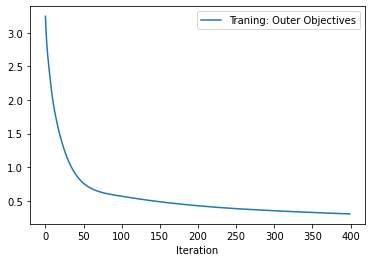

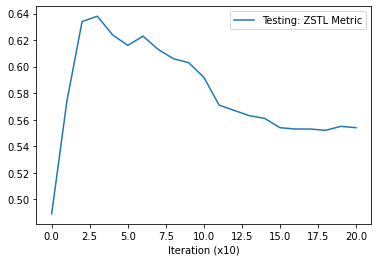

mean metric 0.554
rho for w_kb 0.0001; mu for a_kb 0.0001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 0.04222298040986061
1/400 o_loss 3.2449228748306633; m train metric 0.49119999999999997; m test metric 0.48900000000000005; align loss  0.009695090353488922
20/400 o_loss 1.4773190189898013; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.009585177525877953
40/400 o_loss 0.9062640963075683; m train metric 0.6466; m test metric 0.634; align loss  0.00950041227042675
60/400 o_loss 0.6915346609055996; m train metric 0.7118000000000001; m test metric 0.6380000000000001; align loss  0.009420083835721016
80/400 o_loss 0.6114277797332034; m train metric 0.7384; m test metric 0.624; align loss  0.009341437369585037
100/400 o_loss 0.570936234635301; m train metric 0.7516000000000002; m test metric 0.616; align loss  0.

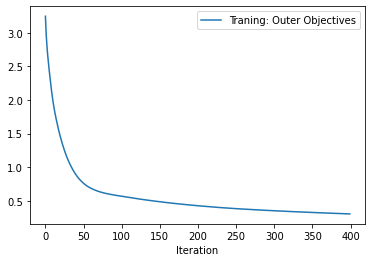

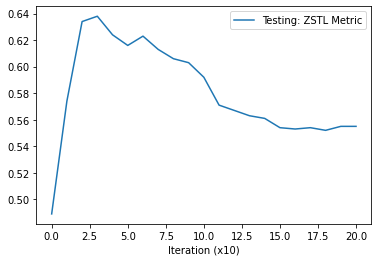

mean metric 0.555
rho for w_kb 0.0001; mu for a_kb 1e-05;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.014232977293431759
1/400 o_loss 3.2449228748306633; m train metric 0.4911999999999999; m test metric 0.489; align loss  0.009689489379525185
20/400 o_loss 1.4773187209665775; m train metric 0.567; m test metric 0.5740000000000001; align loss  0.009579621255397797
40/400 o_loss 0.9062638810044155; m train metric 0.6466; m test metric 0.634; align loss  0.009494908154010773
60/400 o_loss 0.69153459623456; m train metric 0.7118000000000001; m test metric 0.638; align loss  0.009414635598659515
80/400 o_loss 0.6114276605239138; m train metric 0.7384000000000001; m test metric 0.624; align loss  0.009336033836007118
100/400 o_loss 0.570936074894853; m train metric 0.7515999999999999; m test metric 0.616; align loss  0.009258526377379894
120/400 o_loss 0.53476921

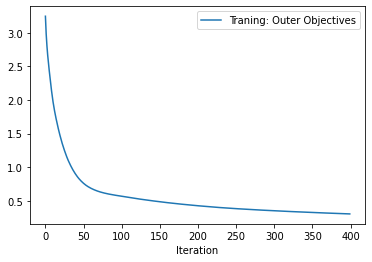

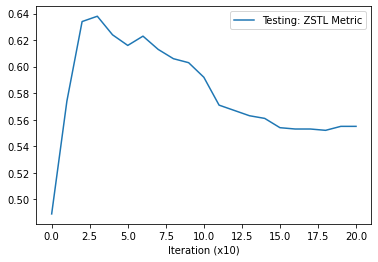

mean metric 0.555
rho for w_kb 1e-05; mu for a_kb 1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 311.0111389160156
1/400 o_loss 3.2431490906025284; m train metric 0.4911999999999999; m test metric 0.48900000000000005; align loss  0.0718994140625
20/400 o_loss 1.4755707210878608; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.071624755859375
40/400 o_loss 0.904527799821226; m train metric 0.6466; m test metric 0.634; align loss  0.0714111328125
60/400 o_loss 0.6898023207526421; m train metric 0.7118000000000001; m test metric 0.6380000000000001; align loss  0.071044921875
80/400 o_loss 0.6096997241699137; m train metric 0.7384000000000001; m test metric 0.624; align loss  0.07086181640625
100/400 o_loss 0.5692203639482614; m train metric 0.7515999999999999; m test metric 0.616; align loss  0.070526123046875
120

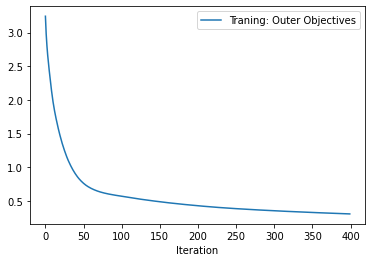

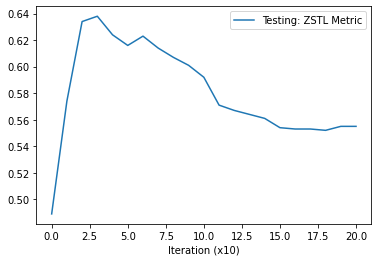

mean metric 0.5549999999999999
rho for w_kb 1e-05; mu for a_kb 0.1;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 31.111127853393555
1/400 o_loss 3.2431490906025284; m train metric 0.49120000000000014; m test metric 0.489; align loss  0.015913009643554688
20/400 o_loss 1.4755706975440261; m train metric 0.5670000000000001; m test metric 0.574; align loss  0.015783309936523438
40/400 o_loss 0.9045277831319254; m train metric 0.6466; m test metric 0.634; align loss  0.015687942504882812
60/400 o_loss 0.6898023094277597; m train metric 0.7118000000000001; m test metric 0.6380000000000001; align loss  0.0155792236328125
80/400 o_loss 0.6096996919397498; m train metric 0.7384; m test metric 0.6239999999999999; align loss  0.0154876708984375
100/400 o_loss 0.5692203520273325; m train metric 0.7515999999999999; m test metric 0.616; align loss  0.015386581420898438
120

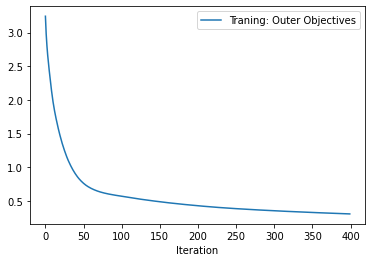

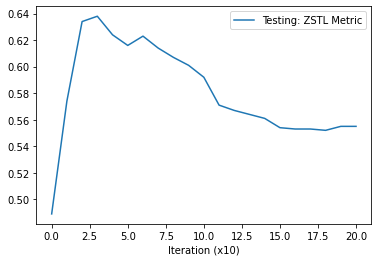

mean metric 0.5549999999999999
rho for w_kb 1e-05; mu for a_kb 0.01;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 3.1211230754852295
1/400 o_loss 3.2431490906025284; m train metric 0.4912; m test metric 0.48900000000000005; align loss  0.010310888290405273
20/400 o_loss 1.4755707461218117; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.010199308395385742
40/400 o_loss 0.9045277759793681; m train metric 0.6466000000000001; m test metric 0.634; align loss  0.01011347770690918
60/400 o_loss 0.6898023171763634; m train metric 0.7117999999999999; m test metric 0.6380000000000001; align loss  0.010030269622802734
80/400 o_loss 0.6096997122489848; m train metric 0.7384000000000001; m test metric 0.624; align loss  0.009950637817382812
100/400 o_loss 0.5692203573917505; m train metric 0.7515999999999999; m test metric 

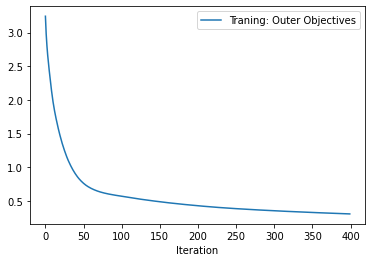

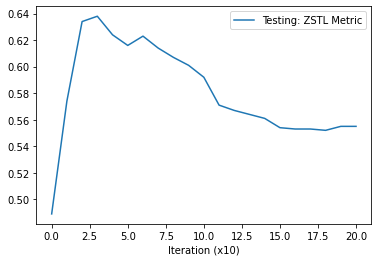

mean metric 0.5549999999999999
rho for w_kb 1e-05; mu for a_kb 0.001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.3221230208873749
1/400 o_loss 3.2431490906025284; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.009751081466674805
20/400 o_loss 1.4755707124451873; m train metric 0.5670000000000002; m test metric 0.5740000000000001; align loss  0.009640991687774658
40/400 o_loss 0.9045277956489008; m train metric 0.6466000000000001; m test metric 0.634; align loss  0.00955614447593689
60/400 o_loss 0.6898023049574112; m train metric 0.7118000000000001; m test metric 0.6380000000000001; align loss  0.009475529193878174
80/400 o_loss 0.609699696751777; m train metric 0.7384; m test metric 0.6239999999999999; align loss  0.009396761655807495
100/400 o_loss 0.569220384809887; m train metric 0.7516000000000002; m test metric 0.616; align lo

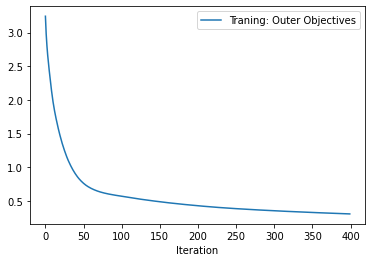

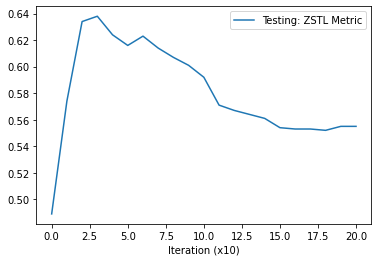

mean metric 0.555
rho for w_kb 1e-05; mu for a_kb 0.0001;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.489; align loss 0.04222298040986061
1/400 o_loss 3.2431490906025284; m train metric 0.49119999999999997; m test metric 0.489; align loss  0.009695090353488922
20/400 o_loss 1.475570642707753; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.009585177525877953
40/400 o_loss 0.9045277765754145; m train metric 0.6466; m test metric 0.634; align loss  0.009500408545136452
60/400 o_loss 0.6898023258190369; m train metric 0.7117999999999999; m test metric 0.638; align loss  0.00942007265985012
80/400 o_loss 0.6096996741020121; m train metric 0.7383999999999997; m test metric 0.6239999999999999; align loss  0.009341411292552948
100/400 o_loss 0.5692203436826822; m train metric 0.7515999999999998; m test metric 0.616; align loss  0.00926384516060352

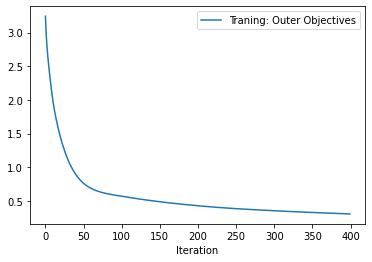

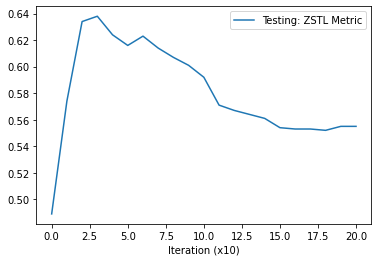

mean metric 0.555
rho for w_kb 1e-05; mu for a_kb 1e-05;
test  torch.Size([85, 5]) torch.Size([2049, 5]) torch.Size([5, 200, 2049]) torch.Size([5, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48900000000000005; align loss 0.014232977293431759
1/400 o_loss 3.2431490906025284; m train metric 0.4911999999999999; m test metric 0.48900000000000005; align loss  0.009689489379525185
20/400 o_loss 1.4755704495887039; m train metric 0.5670000000000001; m test metric 0.5740000000000001; align loss  0.009579619392752647
40/400 o_loss 0.904527598953573; m train metric 0.6466; m test metric 0.634; align loss  0.009494902566075325
60/400 o_loss 0.6898022298555588; m train metric 0.7117999999999999; m test metric 0.6380000000000001; align loss  0.00941462256014347
80/400 o_loss 0.6096995497826719; m train metric 0.7384000000000001; m test metric 0.624; align loss  0.009336009621620178
100/400 o_loss 0.569220230433857; m train metric 0.7515999999999999; m test metric 0.616; align

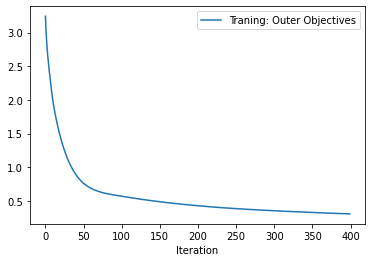

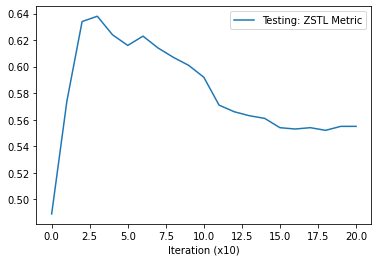

mean metric 0.5549999999999999
best_hp  {'mu': 1e-05, 'rho': 1.0}


In [ ]:
indx = train_indx
val_indx = list(np.random.choice(indx, size=5, replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data = utils.Dataset([dataset[d] for d in val_indx])
train_splited_data = utils.Dataset([dataset[d] for d in train_indx_splited])
val_loader = DataLoader(val_data, batch_size=int(len(val_indx)), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=int(len(train_indx_splited)), shuffle=True)

best_hp = utils.hp_select_binClass(train_splited_loader, val_loader, support_loader, d, dm, net, shape_record, device, val_step=400)
print('best_hp ', best_hp)

In [ ]:
def genSplits(dataset_split, train_size, test_size, support_size, T, train_batch_size=140):
    indx = [ x+1 for x in range(len(dataset_split))]
    support_indx = list(np.random.choice(indx, size=support_size, replace=False))
    print(len(support_indx))
    temp = [x for x in indx if x not in support_indx]
    train_indx = list(np.random.choice(temp, size=train_size, replace=False))
    temp = [x for x in temp if x not in train_indx]
    print(len(train_indx))
    test_indx = temp
    print(len(test_indx))


    support_data = utils.Dataset([dataset_split[d] for d in support_indx])
    train_data = utils.Dataset([dataset_split[d] for d in train_indx])
    test_data = utils.Dataset([dataset_split[d] for d in test_indx])

    support_loader = DataLoader(support_data, batch_size=support_size, shuffle=False)
    train_loader = DataLoader(train_data, batch_size=int(train_size), shuffle=True)
    test_loader = DataLoader(test_data, batch_size=int(test_size), shuffle=True)

    return support_loader, train_loader, test_loader

train_size1 = 30
test_size1 = 10
support_size1 = 10
#print(hp_tune_dataset[0])
support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, len(dataset), train_batch_size=train_size1)

10
30
10


{'rho': 1.0, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.0001, 'align lr': 0.0001, 'dm': 85, 'd': 2049, 'model_shape': {0: [(1, 2049)]}, 'atten_activation': 'Sparsemax'}
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.49250000000000005; align loss 0.012030871585011482
1/700 o_loss 20.368445801734925; m train metric 0.49050000000000005; m test metric 0.49250000000000005; align loss  0.008589469827711582
20/700 o_loss 17.607179403305054; m train metric 0.5333333333333334; m test metric 0.48199999999999993; align loss  0.008507560938596725
40/700 o_loss 15.795607742170493; m train metric 0.5711666666666666; m test metric 0.4800000000000001; align loss  0.00843863282352686
60/700 o_loss 14.318225394189358; m train metric 0.6038333333333331; m test metric 0.477; align loss  0.008372245356440544
80/700 o_loss 13.064768254756927; m train metric 0.6376666666666666; m

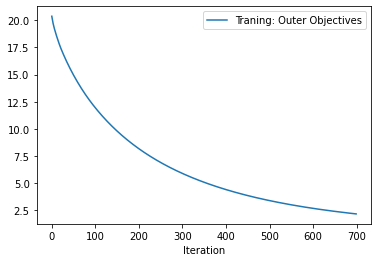

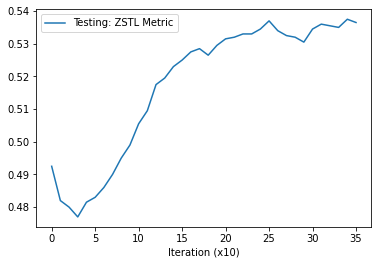

mean acc  tensor(0.5365, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4920000000000001; align loss 0.015227263793349266
1/700 o_loss 19.868248335520427; m train metric 0.4918333333333332; m test metric 0.4920000000000001; align loss  0.012222236953675747
20/700 o_loss 17.0300083309412; m train metric 0.5466666666666666; m test metric 0.49749999999999994; align loss  0.012097510509192944
40/700 o_loss 15.326739992698034; m train metric 0.6031666666666666; m test metric 0.513; align loss  0.011991851031780243
60/700 o_loss 13.941569262742997; m train metric 0.6323333333333334; m test metric 0.5475; align loss  0.011892978101968765
80/700 o_loss 12.770832198858262; m train metric 0.6498333333333334; m test metric 0.5755; align loss  0.01179466862231493
100/700 o_loss 11.753850089510282; m train metric 0.6625000000000001; m test 

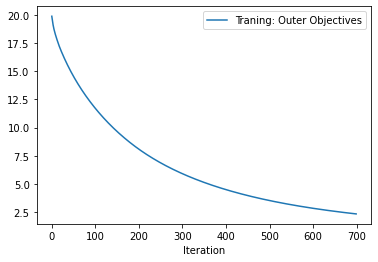

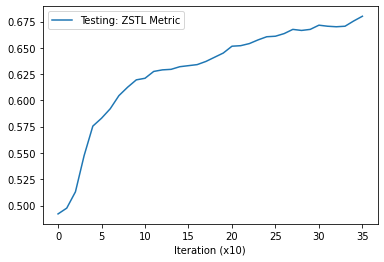

mean acc  tensor(0.6800, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.493; align loss 0.012619619257748127
1/700 o_loss 20.773340876897176; m train metric 0.4916666666666666; m test metric 0.493; align loss  0.009431923739612103
20/700 o_loss 17.935706372062366; m train metric 0.5411666666666668; m test metric 0.49499999999999994; align loss  0.009335555136203766
40/700 o_loss 16.129922213157016; m train metric 0.5771666666666666; m test metric 0.515; align loss  0.009263371117413044
60/700 o_loss 14.660542908807596; m train metric 0.6140000000000001; m test metric 0.5245; align loss  0.009196106344461441
80/700 o_loss 13.419301182031631; m train metric 0.6401666666666668; m test metric 0.5329999999999999; align loss  0.00912671908736229
100/700 o_loss 12.33908314059178; m train metric 0.6588333333333332; m test metric 0.545;

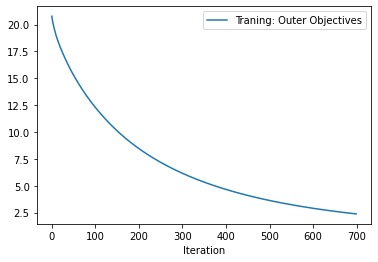

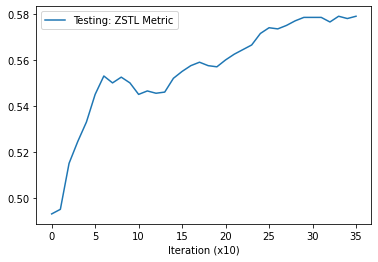

mean acc  tensor(0.5790, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4925; align loss 0.013788627460598946
1/700 o_loss 22.61073029836019; m train metric 0.49000000000000005; m test metric 0.4925; align loss  0.010184865444898605
20/700 o_loss 19.73960289657116; m train metric 0.5468333333333333; m test metric 0.5315; align loss  0.010089259594678879
40/700 o_loss 17.82254496216774; m train metric 0.5796666666666666; m test metric 0.5694999999999999; align loss  0.010020929388701916
60/700 o_loss 16.239876223107178; m train metric 0.6106666666666665; m test metric 0.588; align loss  0.009954606182873249
80/700 o_loss 14.892757036288579; m train metric 0.6376666666666666; m test metric 0.59; align loss  0.009887464344501495
100/700 o_loss 13.717848537365596; m train metric 0.6621666666666669; m test metric 0.5955000000000001;

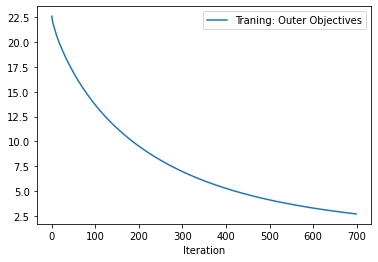

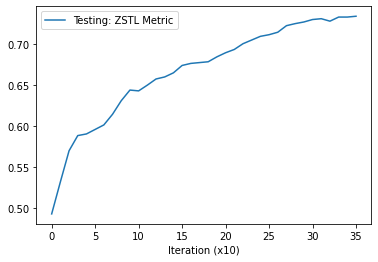

mean acc  tensor(0.7335, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.49400000000000005; align loss 0.01012925524264574
1/700 o_loss 19.10654355684916; m train metric 0.4901666666666667; m test metric 0.49400000000000005; align loss  0.0075936755165457726
20/700 o_loss 16.303349742293356; m train metric 0.5389999999999998; m test metric 0.513; align loss  0.00750565342605114
40/700 o_loss 14.619815762837728; m train metric 0.5908333333333332; m test metric 0.5165; align loss  0.007443175185471773
60/700 o_loss 13.27168490042289; m train metric 0.6171666666666664; m test metric 0.52; align loss  0.007388888858258724
80/700 o_loss 12.126617195208867; m train metric 0.6323333333333334; m test metric 0.5200000000000001; align loss  0.007334599737077951
100/700 o_loss 11.129917521774768; m train metric 0.6385000000000001; m test m

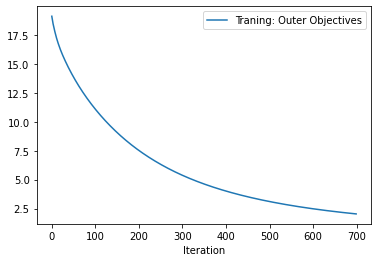

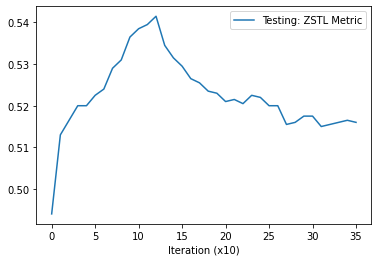

mean acc  tensor(0.5160, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48950000000000005; align loss 0.015217863023281097
1/700 o_loss 18.511860783894857; m train metric 0.4911666666666666; m test metric 0.48950000000000005; align loss  0.01149755623191595
20/700 o_loss 15.809396502872309; m train metric 0.5301666666666667; m test metric 0.5925; align loss  0.011389758437871933
40/700 o_loss 14.026335127651691; m train metric 0.5526666666666665; m test metric 0.6195000000000002; align loss  0.011306557804346085
60/700 o_loss 12.59829428444306; m train metric 0.5943333333333334; m test metric 0.6695; align loss  0.011223817244172096
80/700 o_loss 11.431265340248743; m train metric 0.6275; m test metric 0.6950000000000001; align loss  0.011141360737383366
100/700 o_loss 10.443901700278124; m train metric 0.6526666666666665; m te

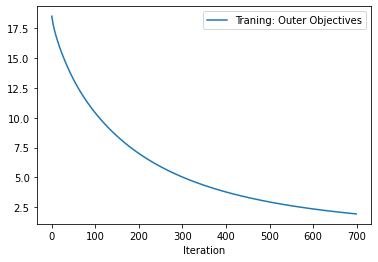

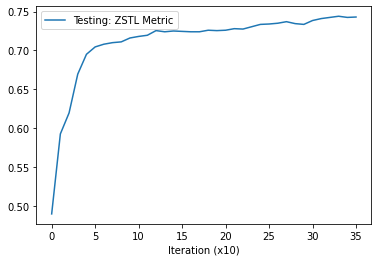

mean acc  tensor(0.7430, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.49300000000000005; align loss 0.013110692612826824
1/700 o_loss 19.10576611359914; m train metric 0.49000000000000005; m test metric 0.49300000000000005; align loss  0.010161120444536209
20/700 o_loss 16.37361124654611; m train metric 0.5121666666666668; m test metric 0.5050000000000001; align loss  0.010073520243167877
40/700 o_loss 14.554980748395124; m train metric 0.5506666666666667; m test metric 0.51; align loss  0.009998457506299019
60/700 o_loss 13.138209913671016; m train metric 0.6173333333333332; m test metric 0.513; align loss  0.00992763414978981
80/700 o_loss 11.990757128596305; m train metric 0.6526666666666667; m test metric 0.515; align loss  0.00985895749181509
100/700 o_loss 11.014362726608912; m train metric 0.6799999999999999; m test me

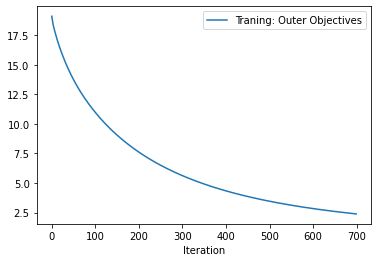

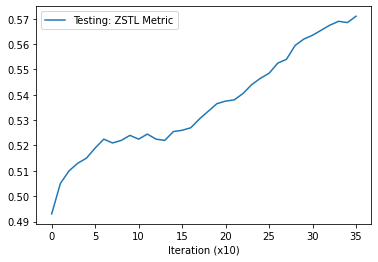

mean acc  tensor(0.5710, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4925; align loss 0.01431148312985897
1/700 o_loss 21.317254583040874; m train metric 0.4909999999999999; m test metric 0.4925; align loss  0.011383729055523872
20/700 o_loss 18.3221373980244; m train metric 0.5191666666666667; m test metric 0.495; align loss  0.01127588003873825
40/700 o_loss 16.427757433056833; m train metric 0.5571666666666667; m test metric 0.51; align loss  0.011187383905053139
60/700 o_loss 14.906665969391664; m train metric 0.5928333333333333; m test metric 0.538; align loss  0.011098476126790047
80/700 o_loss 13.652114052077135; m train metric 0.6305; m test metric 0.558; align loss  0.011010473594069481
100/700 o_loss 12.567635441819826; m train metric 0.6536666666666665; m test metric 0.5685; align loss  0.010922457091510296
120/70

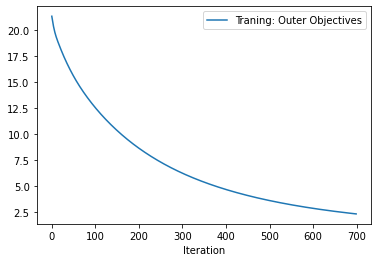

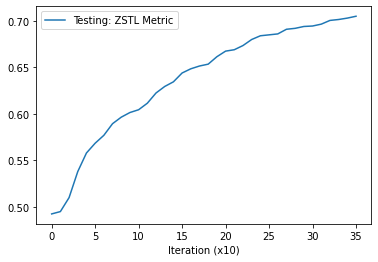

mean acc  tensor(0.7050, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.493; align loss 0.014053849503397942
1/700 o_loss 21.880496899286907; m train metric 0.49116666666666664; m test metric 0.493; align loss  0.010123425163328648
20/700 o_loss 19.207426891724268; m train metric 0.49800000000000005; m test metric 0.48549999999999993; align loss  0.010026877745985985
40/700 o_loss 17.34384141465028; m train metric 0.5288333333333334; m test metric 0.511; align loss  0.009946886450052261
60/700 o_loss 15.79347591996193; m train metric 0.5571666666666668; m test metric 0.5335; align loss  0.009869775734841824
80/700 o_loss 14.457541600863138; m train metric 0.5821666666666665; m test metric 0.554; align loss  0.009796464815735817
100/700 o_loss 13.295521494746207; m train metric 0.6061666666666666; m test metric 0.574000000000000

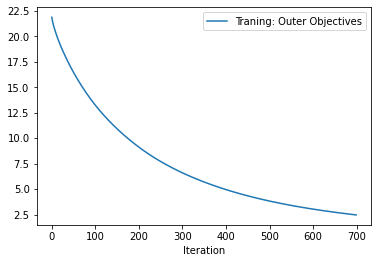

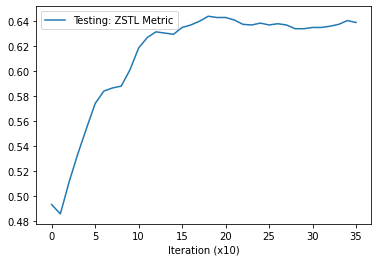

mean acc  tensor(0.6390, device='cuda:0', dtype=torch.float64)
10
30
10
test  torch.Size([85, 10]) torch.Size([2049, 10]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.48949999999999994; align loss 0.010703702457249165
1/700 o_loss 19.38481965859731; m train metric 0.4914999999999999; m test metric 0.489; align loss  0.00750631932169199
20/700 o_loss 16.795485003789267; m train metric 0.49616666666666664; m test metric 0.521; align loss  0.007435261271893978
40/700 o_loss 15.0204514503479; m train metric 0.514; m test metric 0.5345; align loss  0.007378758862614632
60/700 o_loss 13.585839240749678; m train metric 0.5468333333333333; m test metric 0.5454999999999999; align loss  0.007320047356188297
80/700 o_loss 12.392395478487014; m train metric 0.565; m test metric 0.5605; align loss  0.0072615924291312695
100/700 o_loss 11.360965718328952; m train metric 0.5745000000000001; m test metric 0.5889999999999999; align loss 

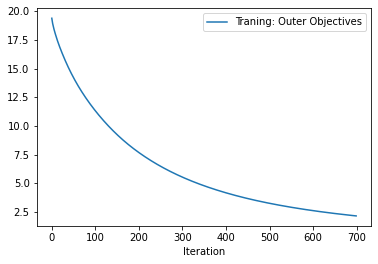

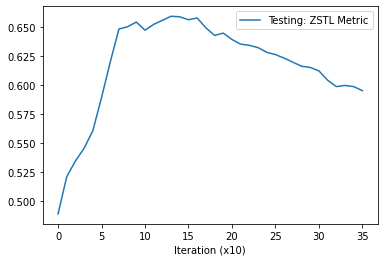

mean acc  tensor(0.5950, device='cuda:0', dtype=torch.float64)


In [ ]:
exp_results = []
Run = 10

param_dict = {}
param_dict['rho'] = best_hp['rho']
param_dict['mu'] = best_hp['mu']
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-4
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)

for r in range(Run):
    support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, len(dataset), train_batch_size=train_size1)
    support_a, support_w, support_x, support_y = next(iter(support_loader))
    support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
    support_a = support_a.squeeze().t()
    support_w = support_w.squeeze().t()
    ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
    ZSTL_model.train(train_loader, test_loader, max_iter=700)
    mean_acc = ZSTL_model.zero_shot_transfer(test_loader)
    print('mean acc ', mean_acc)
    exp_results.append(utils.toNumpy(mean_acc.cpu()))


In [ ]:
import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)

[array(0.5365), array(0.68), array(0.579), array(0.7335), array(0.516), array(0.743), array(0.571), array(0.705), array(0.639), array(0.595)]
0.6298
(0.5710360922038111, 0.6885639077961889)
[-0.05876391  0.05876391]


In [ ]:
param_dict

{'align lr': 0.0001,
 'atten_activation': 'Sparsemax',
 'd': 2049,
 'dm': 85,
 'loss': 'binary class',
 'model_shape': {0: [(1, 2049)]},
 'mu': 1e-05,
 'outer lr': 0.0001,
 'rho': 1.0}